### Setup

In [87]:
%run utils/utils_data_cleaning.py

import matplotlib.pyplot as plt

### Load a subset of the dataset

In [88]:
df = load_taxi_data_chunk(chunk=50000)
handle_missing_data(df)
df.head()

Data loaded with 50000 entries and 10 columns
Size reduction from 50000 to 48804 (1196 samples dropped for missing data)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### Target histogram (duration)

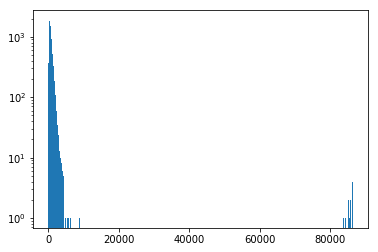

In [89]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.show()

Consindering the durations above 80k seconds (22 hours) as noise, let's zoom in a bit:

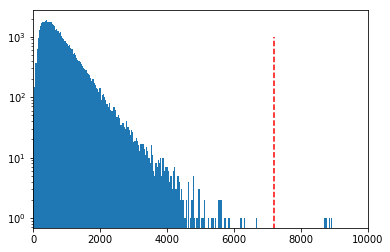

In [90]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.xlim(0,10000)
plt.plot((7200, 7200),(0,1e3), '--', c='r')
plt.show()

Seems reasonable to filter out any trips taking longer than 2 hours. 

In [91]:
print("{0:.2f}% of the trips last less than 2 hours".format(100*(df.duration < 7200).sum()/df.shape[0]))

99.83% of the trips last less than 2 hours


### Remove samples with too long duration (considered as outliers) 

In [92]:
print('# of duration outliers =', df[(df.duration > 7200)].shape[0])
handle_duration_outliers(df, 7200)

# of duration outliers = 83
Size reduction from 48804 to 48721 (83 samples dropped for having longer duration than 7200 seconds)


### Replot target histogram (duration) 

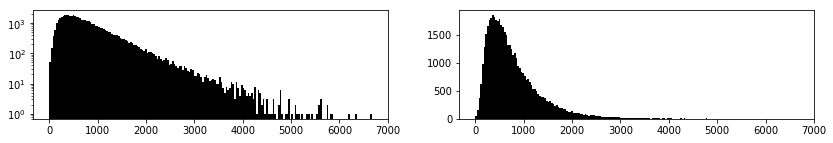

In [149]:
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
plt.hist(df.duration, bins='auto', log=True, color='k')
plt.subplot(1,2,2)
plt.hist(df.duration, bins='auto', log=False, color='k')
plt.show()

### Fit some distributions

- Normalize first:

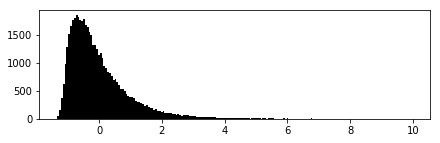

In [155]:
normalized_duration = (df.duration - df.duration.mean())/df.duration.std()
plt.figure(figsize=(7,2))
_,x,_ = plt.hist(normalized_duration, bins='auto', color='k')

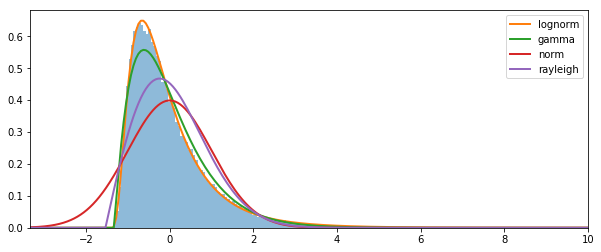

In [164]:
import numpy as np
from scipy import stats

plt.figure(figsize=(10,4))

plt.hist(normalized_duration, bins='auto', alpha=0.5, density=True)

dist_names = ['lognorm', 'gamma', 'norm', 'rayleigh']
parameters = []

left_x = np.linspace(x.min() - 2, x.min(), 1000)
x_axis = np.concatenate((left_x, x))

for dist_name in dist_names:
    
    dist = getattr(stats, dist_name)
    param = dist.fit(normalized_duration)
    parameters.append(param)
    
    shape = param[:-2]
    loc = param[-2]
    scale = param[-1]

    pdf_fitted = dist.pdf(x_axis, *param[:-2], loc=param[-2], scale=param[-1])
    plt.plot(x_axis, pdf_fitted, label=dist_name, linewidth=2)
    plt.xlim((x_axis.min(),10))
    plt.legend(loc='upper right')
plt.show()

### Pick-up / drop-off time histograms

In [8]:
# Measured in hours of a day
df['pu_hour'] = df.pu_t.apply(lambda s: s.hour)
df['do_hour'] = df.do_t.apply(lambda s: s.hour)

# Measured in seconds of a day
df['pu_second'] = df.pu_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)
df['do_second'] = df.do_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)

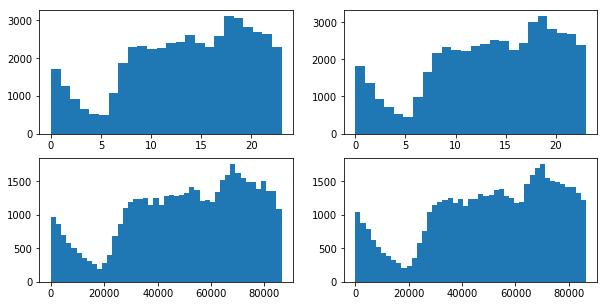

In [9]:
time_data = [df.pu_hour, df.do_hour, df.pu_second, df.do_second]

fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

ax[0].hist(time_data[0], bins=24)
ax[1].hist(time_data[1], bins=24)
ax[2].hist(time_data[2], bins='auto')
ax[3].hist(time_data[3], bins='auto')

plt.show()  

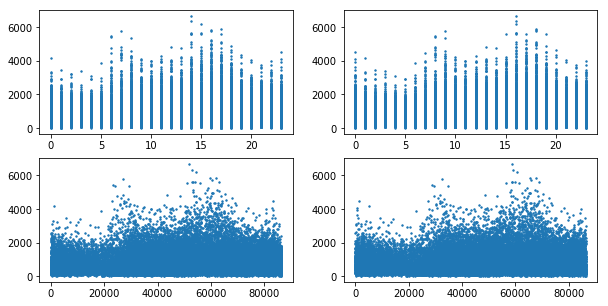

In [10]:
fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
ax[0].scatter(time_data[0], df.duration, s=2)
ax[1].scatter(time_data[1], df.duration, s=2)
ax[2].scatter(time_data[2], df.duration, s=2)
ax[3].scatter(time_data[3], df.duration, s=2)

plt.show()